<a href="https://colab.research.google.com/github/TSupattra/BADS7105_CRM_Analytics/blob/main/07_Voice%20of%20Customer/Clustering_Documents_Universal_Sentence_Encoder_with_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 5.1 MB/s 
     |████████████████████████████████| 743 kB 53.8 MB/s 
     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 33.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=867e29eb2a728b42d0f035fbd73269472b8e79afb02fadf4cc30bfcde447c7fc
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=dbd0ab2fbd24865cd3dad2b33ce39d89a9364b911bd4ed7e6d97cb84a06e864e
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("WongnaiReviews_Small.csv")

In [6]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [7]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [8]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

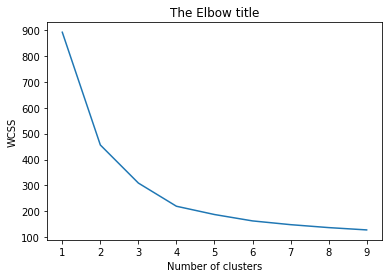

In [9]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [10]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [11]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [12]:
df_kmeans

,KMeans ID,texts
0,0,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
1,1,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
2,2,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [13]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [14]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [15]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [16]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [17]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [18]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [19]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน','น','กิน','อร่อย','ทาน','ๆๆ','นะคะ','กา','บอ','ศ','ส','าน','รา','ข','น','กก','เม','ร้า','เ','อย','รี่',':','ท','ผม','สวัสดี','ดิชั้น','[',']','(',')','-','รับประทาน','tamp','nTamp','--',"']","['",'?',"']", 'โมง','เวลา','โอเค','และ','nn------------','review' ]
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [20]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [21]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (ซอย, 6), (อาหาร, 6), (ราคา,..."
1,1,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(รีวิว, 7), (บ้าน, 5), (ร้านกาแฟ, 5), (กาแฟ, ..."
2,2,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, นึง, เด, Artof...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ชอบ, 8), (คาเฟ่,..."
3,3,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."


In [22]:
df_kmeans['texts'][0]

'กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คสวัสดีเพื่อนๆสมาชิกนักรีวิวร้านอาหารชาวWongnaร้านส้มตำเจ๊พิมอยู่ถนนเลี่ยงตลาดหนองมนnเป็นร้ตอนเย็นๆหน่อยถ้าลงจากรถไฟฟ้าราชเทวีแล้วเดินย้อแมทช์นี้ที่หัวหินระหว่างที่ยังตกลงว่าทานกลมีคนแนะนำมาว่าต้องร้านนี้nเลยขอลองสักหน่อยไร้านตกแต่งน่ารักมากสไตล์นั่งอยู่ในบ้านก็จะมีขร้านอาหารเรื่อนปั้นหยาที่จอดรถกว้างขวางสะดวกสร้านอาหารไทยฟิวชั่นอร่อยสะอาดแต่ราคาสูงไปนิสาระพัดยำแบบแซ่บๆราคาไม่แพงnnร้านยำแซ่บสาเป็นร้านที่ได้ผักเยอะมากกกกกกกกกกกอร่อยคุ้มราร้านก๋วยเตี๋ยวเป็นร้านเก่าแก่ครองใจคนชลบุร้านเชฟมดรอบนี้มาจัดเป็นรอบที่สองหลังจากถูกใจริงๆจะไปกินร้านอื่นครับที่อยู่ในซอยเดียวกันแมีใครทำงานหรืออาศัยในย่านธุรกิจอย่างสุขุมวิทบ้โดยส่วนตัวแล้วไปทานที่ร้านแบล๊กแคนยอนที่สาขารามาถึงเมืองชลอีกครั้งค่าจาไปพัทยาแต่มอเตอร์เวร้านขายเป็ดห่านพะโล้เก่าแก่เขาเคลมว่าไม่มีสาขมีทั้งอาหารไทยและอาหารอีสานให้เลือกทานเมนูหลาขับรถเข้ามาในซอยโรงพยาบาลสมิติเวช(สุขุมวิทร้านกินดื่มแบบญี่ปุ่นหรืออิซากายะเป็นร้านอาหร้านนี้โฆษณาว่ามีเบียร์แช่เย็นเป็นวุ้นขายด้วอาหารอร่อยหลากหลายเมนูส้มตำอ

In [23]:
df_kmeans['texts'][1]

'วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้านเป็นร้านที่สะดุดตาที่สุดบนถนนจรัญเลยก็ว่าได้สถานที่ตั้งร้านปากซอยสุขุมวิทบริเวณด้านซขอไปกินกับเค้าบ้างเหอะแหมอยู่ใกล้บ้านตั้งขนาคิดถึงร้านนี้มากสมัยเรียนพิเศษที่ดาวองก์เยาวรเดือนแรกที่เค้าต่อคิวกัน-ชั่วโมงเราก็ว่หันไปหันมาอยากไปแตะขอบฟ้าบ้างอะไรบ้างจะไปถึงร้านนี้ใครๆก็รู้จักว่าเป็นร้านกาแฟแต่อาหารขอร้านนี้เป็นของดาราตลกชื่อดังค่ะคุณหม่ำนั่นเองปังภูเขาไฟกับอ่กาศร้อนๆเข้ากันฝุดๆnหวานๆอร่ใครรักข้าวห่อไข่มาจานนี้จะจุใจมากเพราะเมนูเกมาครั้งแรกจะไปตัดสินใจอะไรได้น้อผมเดินจากลานจโดยส่วนตัวชอบIcecaramelmacchiatoที่สุดเพราสารภาพว่าไม่เคยคิดจะไปต่อคิวซื้อมากินเองครับบnn------------เกริ่นๆๆnnทริปลงใต้ครั้งนี้ร้านจะเป็นร้านนั่งแทบจะติดทะเลเลยนะคะอารมณ์ชามีโอกาสได้ไปกินไอติมที่ร้านนี้มาชอบตั้งแต่การมาคนเดียวเดินเลือกอยู่นานอยากกินอะไรที่ไม่อ้ที่บอกว่าขอลบดาวออกดวงเพราะว่าคราวก่อนเคยมตอนแรกนึกว่าไม่อร่อยเลยลองเล่นๆปรากฎอร่อยมากผมเห็นรีวิวจากคุณRiceMangoผมก็หาโอกาสว่างตามร้านเค๊กที่ถูกพูดถึงอย่างมากเรียกได้ว่

In [24]:
df_kmeans['texts'][2]

"เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArtofCoffeeKasetsartเป็นร้านกาแฟรสชาติเยี่Starbucksnเกี่ยวกับร้าน:nร้านStarbucksนีnร้านเบอเกอรี่ร้านนี้อยู่ในร้านล้างรถชื่อว่าโลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้านนึงค่ร้านกาแฟและเบเกอรี่โฮมเมดอร่อยๆกับสไสต์การแต่ร้าน-cakeร้านกาแฟแอนด์เบเกอรี่เป็นร้านกาแฟไปทานมาเพราะเห็นเปิดแบบบุฟเฟต์ทุกวันเสาร์อาทิตเคยทานทองม้วนสดมาหลายร้านแล้วnถ้าจะทานแบบอร่ร้านกาแฟร้านนี้เมื่อเข้าไปแล้วบรรยายกาศจะออกแร้านอาหารและเครื่องดื่มที่ราคาเป็นกันเองมากๆานพายจริณเป็นร้านคาเฟ่และเบเกอรี่เล็กๆที่มีสาร้านกาแฟนรสิงห์ณวังพญาไทnnได้ยินชื่อร้านการ้านนี้เป็นร้านกาแฟแนวน่ารักแนวๆขายกาแฟก็แนวๆร้านใหม่พึ่งเปิดได้เดือนเลยมาลองดูไม่ผิดหร้านนี้เป็นอีกร้านที่ติดใจเพราะเคยได้ลองทมาช๊อปปิ้งในห้างและเอารถมาล้างที่โปรคลีนประวปกติมาแถวนี้กินแต่stbลองวิสต้าคาเฟ่บ้างชอบบรเหมือนร้านจะย้ายมาจากใต้ดิอิมเพรสป่าวไม่มั่นนัดกับรุ่นน้องไว้ว่าจะพาไปเลี้ยงและอยากทานกาแฟส่วนตัวชอบทานกาแฟยี่ห้อนี้อยุ่ด้วยผมว่ากลิ่นหร้านนี้น่าจะเป็นCatCafeร้านแรกของประเทศไทยระหว่างรอจัดงานลอยกระทงเลยมานั่งพักดื่ม

In [25]:
df_kmeans['texts'][3]

'เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช้าๆบ่ายๆหรือเย็นๆอาหารว่างที่คนเรามักหยิบจัระหว่างมุ่งหน้าสู่ชัยภูมิเราแวะเติมพลังกันที่เป็นร้านเครื่องดื่มขนาดกระทัดรัดพื้นที่น้อยเร้านขายเครื่องดื่มผลิตภัณฑ์ชาเขียวไอศรีมชาเขีชานมไข่มุกจริงๆคืออ้วนมากnไม่ค่อยอยากกินเลยเดินผ่านร้านนี้มาหลายครั้งแล้วค่ะสังเกตว่าร้าร้านอยู่โซนซุ้มขายของเล็กๆตรงกลางนะคะใกล้ๆกับบนห้างBig-Cราชดำรินิวคุงได้ไปเจอร้านขายน้ำทน่าจะใช่นะOchayaมีสาขาเยอะมากๆทั้งตึกออฟฟร้านAprilstoreเป็นร้านกาแฟขนาดเล็กตั้งอยู่วันนี้มาเดินเที่ยวสยามคะถ้าชาไข่มุกอร่อยๆต้องร้านAprilstoreอยู่บริเวณสวนของยูเซ็นเตอร์วันก่อนนิวคุงไปเดินเล่นหาอะไรกินในย่านหอการค้าวันนี้ได้ฤกษ์มารีวิวร้านชานมไข่มุกร้านที่โปรดเป็นคนชอบทานชาไข่มุกลองมาแล้วหลายร้านติดใจรสร้านALittleSweetเป็นร้านของหวานสไตล์dessennnnnร้านDakasiเป็นร้านเครื่องดื่มครับร้านวโรชาเป็นร้านก๋วยเตี๋ยวเล็กๆที่เปิดมานานร้านชานมไข่มุกร้านนี้ที่เราจะมาแนะนำมีชื่อร้ายจากโปรโมชั่นของopenriceทำให้ได้ลองชิมชายี่ห้มาเดินโฮมโปรกับหลานคุณหลานเกิดอยากดื่มชานมหวTeaStoryร้านชานมไข่มุกกิ๊บเก๋ตั้งอยู่กล

In [31]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านอาหาร', 11), ('ซอย', 6), ('อาหาร', 6), ('ราคา', 5), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('รีวิว', 3)]

Cluster ID : 1

Most common words include : [('รีวิว', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('อาหาร', 4), ('ชอบ', 4), ('ร้านอาหาร', 4), ('มีโอกาส', 3), ('ถนน', 3), ('คิว', 3)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ชอบ', 8), ('คาเฟ่', 6), ('แวะ', 6), ('น่ารัก', 5), ('นั่ง', 5), ('เจอ', 5), ('คน', 4), ('นึง', 4)]

Cluster ID : 3

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('ตั้งอยู่', 3), ('รีวิว', 3), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ไหม', 2)]



## Cluster ID : 0  Top 20


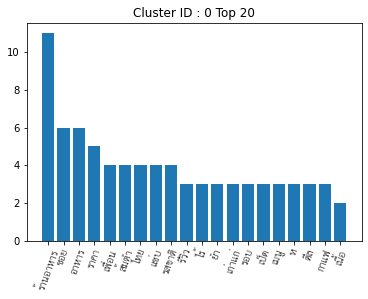

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='THSarabun.ttf')  # speicify font
top20 = list(df_kmeans['texts_count'][0])[:20]
plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
plt.xticks(range(len(top20)), [val[0] for val in top20], fontproperties=font,fontsize = 15)
plt.xticks(rotation=70)
# displaying the title
plt.title("Cluster ID : 0 Top 20")
plt.savefig('voice_kmean_0.png')
plt.show()



## Cluster ID : 1  Top 20

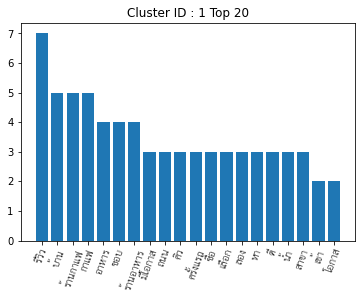

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='THSarabun.ttf')  # speicify font
top20 = list(df_kmeans['texts_count'][1])[:20]
plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
plt.xticks(range(len(top20)), [val[0] for val in top20], fontproperties=font,fontsize = 15)
plt.xticks(rotation=70)
# displaying the title
plt.title("Cluster ID : 1 Top 20")
plt.savefig('voice_kmean_1.png')
plt.show()


## Cluster ID : 2  Top 20

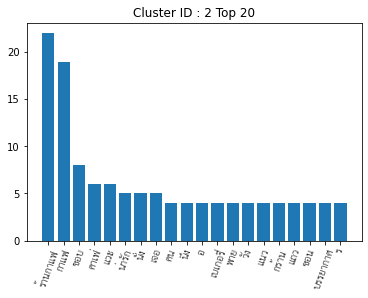

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='THSarabun.ttf')  # speicify font
top20 = list(df_kmeans['texts_count'][2])[:20]
plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
plt.xticks(range(len(top20)), [val[0] for val in top20], fontproperties=font,fontsize = 15)
plt.xticks(rotation=70)
# displaying the title
plt.title("Cluster ID : 2 Top 20")
plt.savefig('voice_kmean_2.png')
plt.show()


## Cluster ID : 3  Top 20

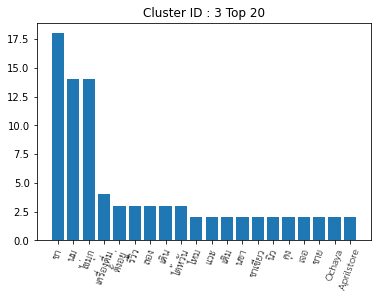

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='THSarabun.ttf')  # speicify font
top20 = list(df_kmeans['texts_count'][3])[:20]
plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
plt.xticks(range(len(top20)), [val[0] for val in top20], fontproperties=font,fontsize = 15)
plt.xticks(rotation=70)
# displaying the title
plt.title("Cluster ID : 3 Top 20")
plt.savefig('voice_kmean_3.png')
plt.show()

## Result discussion

Cluster ID : 0

เกี่ยวกับการรีวิวร้านอาหาร ที่มีกาแฟด้วย


Cluster ID : 1

เกี่ยวกับร้านอาหาร การรีวิวร้านอาหาร ด้านรสชาติ ราคา เช่น ร้านส้มตำ ยำ

Cluster ID : 2

เกี่ยวกับร้านกาเฟ่ คาเฟ่ เบเกอรี่ ที่เป็นแนวน่ารัก สามารถนั่งรับประทานได้ บรรยากาศดี


Cluster ID : 3

เกี่ยวกับเครื่องดื่มประเภท ชานมไข่มุก ชาเขียว 







**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [27]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [28]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [29]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [30]:
#show top keywords of each cluster

top_N_words = 50

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('รสชาติ', 407), ('ดี', 347), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273), ('ชา', 262), ('บาท', 242), ('ชอบ', 229), ('คน', 215), ("','", 215), ('หวาน', 206), ('นั่ง', 201), ('จาน', 196), ('ลอง', 178), ('บรรยากาศ', 151), ('นม', 149), ('ดู', 147), ('เค้า', 136), ('หอม', 136), ('รส', 136), ('เค้ก', 132), ('เนื้อ', 130), ('เลือก', 126), ('เครื่องดื่ม', 122), ('บริการ', 116), ('น้ำ', 111), ('โต๊ะ', 109), ('ใส่', 107), ('เหมือน', 107), ('หมู', 107), ('ไข่มุก', 107), ('สำหรับ', 103), ('ขาย', 99), ('ร้านกาแฟ', 97), ('แนะนำ', 95), ('ที่นี่', 94), ('แก้ว', 93), ('ทำ', 93), ('ส้มตำ', 88), ('ปลา', 87), ('กรอบ', 86), ('ชิ้น', 83), ('"', 82), ('แพง', 80), ('ไทย', 80), ('ตัว', 80), ('ชิม', 79), ('ร้อน', 78)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('แก้', 3), ('อาหาร', 3), ('ร่างกาย', 3), ('เมล็ด', 2), ('มีรส', 2


## Cluster ID : 0  Top 20

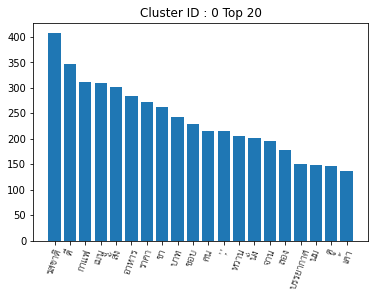

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='THSarabun.ttf')  # speicify font
top20 = list(df_Agglomerative['texts_count'][0])[:20]
plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
plt.xticks(range(len(top20)), [val[0] for val in top20], fontproperties=font,fontsize = 15)
plt.xticks(rotation=70)
# displaying the title
plt.title("Cluster ID : 0 Top 20")
plt.savefig('voice_cosine_0.png')
plt.show()


## Cluster ID : 1  Top 20

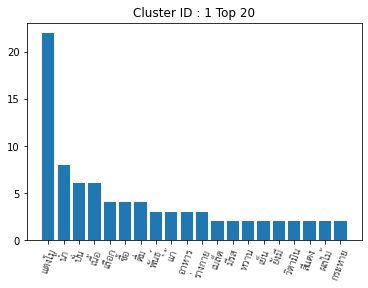

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='THSarabun.ttf')  # speicify font
top20 = list(df_Agglomerative['texts_count'][1])[:20]
plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
plt.xticks(range(len(top20)), [val[0] for val in top20], fontproperties=font,fontsize = 15)
plt.xticks(rotation=70)
# displaying the title
plt.title("Cluster ID : 1 Top 20")
plt.savefig('voice_cosine_1.png')
plt.show()


## Cluster ID : 2  Top 20

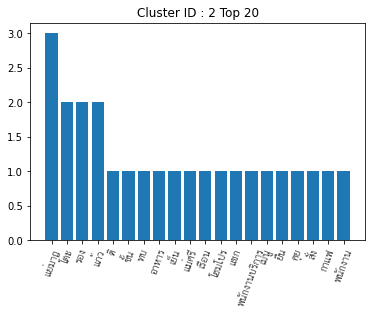

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='THSarabun.ttf')  # speicify font
top20 = list(df_Agglomerative['texts_count'][2])[:20]
plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
plt.xticks(range(len(top20)), [val[0] for val in top20], fontproperties=font,fontsize = 15)
plt.xticks(rotation=70)
# displaying the title
plt.title("Cluster ID : 2 Top 20")
plt.savefig('voice_cosine_2.png')
plt.show()


## Cluster ID : 3  Top 20

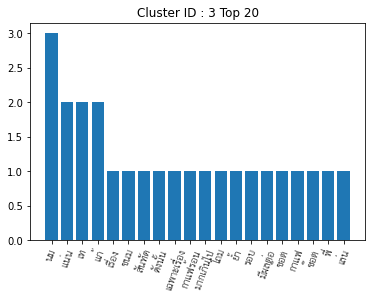

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='THSarabun.ttf')  # speicify font
top20 = list(df_Agglomerative['texts_count'][3])[:20]
plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
plt.xticks(range(len(top20)), [val[0] for val in top20], fontproperties=font,fontsize = 15)
plt.xticks(rotation=70)
# displaying the title
plt.title("Cluster ID : 3 Top 20")
plt.savefig('voice_cosine_3.png')
plt.show()

## Result discussion

Cluster ID : 0

เกี่ยวกับรสชาติ ราคา บรรยากาศ และการบริการของร้านอาหาร

Cluster ID : 1

เกี่ยวกับเครื่องดื่มประเภทปั่น แตงโมปั่นมีที่มีรสหวาน มีวิตามิน แก้กระหาย เย็น

Cluster ID : 2

เกี่ยวกับการรีวิวร้านอาหารในเรื่องที่ไม่พอใจ ซึ่งดูจากคำว่าแย่มาก

Cluster ID : 3

-